In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import sklearn
from sklearn.model_selection import train_test_split
from itertools import permutations 
from scipy import stats
import random
from sklearn.metrics import confusion_matrix
from PIL import Image
import os, sys
from skimage.io import imread_collection

In [39]:
import importlib, importlib.util

def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

In [40]:
MLNN = module_from_file("myclasses", "MLNN.py")

In [7]:
def resize(path, path_new):
    dirs = os.listdir( path )
    i = 0
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((256,256), Image.ANTIALIAS)
            imResize.save(path_new + str(i) + '.jpg', 'JPEG', quality=100)
            i += 1

In [2]:
def partition(A):
    matr = []
    for i in range(8):
        for j in range(8):
            a = i*32
            b = j*32
            matr.append(A[a:a+32,b:b+32])
    return matr

In [3]:
def binRepresentation(image):
    
    bins = [0,32,64,96,128,160,192,224,256]
    im = image.reshape(3,256,256)
    res = np.zeros((64,1))
    
    for i in range(3):
        
        matrices = partition(im[i])
        EachColor = np.zeros(8)
        for j in range(len(matrices)):
            
            p = matrices[j].reshape(1,32*32)[0]
            bin_indices = np.digitize(p, bins)
            sr = pd.Series(bin_indices)
            sr = sr.value_counts()
            d = np.zeros(8)
            for k in range(8):
                try:
                    d[k] = sr[k+1]
                except:
                    'EOF'
            EachColor = np.vstack((EachColor, d))
        
        EachColor = EachColor[1:,:]
    
        res = np.hstack((res,EachColor))
        
    return res[:,1:]

In [4]:
def AllClassesBinRepresentation(data):
    
    k = len(data)
    
    for i in range(k):
        
        for j in range(len(data[i])):
            
            if(j == 0):
                eachImage = binRepresentation(data[i][j])
            else:
                eachImage = np.vstack((eachImage, binRepresentation(data[i][j])))
                
        if(i == 0):
            res = eachImage
        else:
            res = np.vstack((res, eachImage))
            
    return res

In [5]:
f1 = 'Dataset/Classification/Image_Group17/train/formal_garden/'
f2 = 'Dataset/Classification/Image_Group17/train/engine_room/'
f3 = 'Dataset/Classification/Image_Group17/train/basement/'

f1_new = 'Dataset/Classification/Image_Group17/train/formal_garden_resized/'
f2_new = 'Dataset/Classification/Image_Group17/train/engine_room_resized/'
f3_new = 'Dataset/Classification/Image_Group17/train/basement_resized/'

In [8]:
resize(f1, f1_new)
resize(f2, f2_new)
resize(f3, f3_new)

In [9]:
ext = "*.jpg"
classes = [0]*3
classes[0] = imread_collection(f1_new+ext)
classes[1] = imread_collection(f2_new+ext)
classes[2] = imread_collection(f3_new+ext)

In [10]:
dfTrain = AllClassesBinRepresentation(classes)

In [11]:
dfTrain.shape

(9600, 24)

In [12]:
f1_test = 'Dataset/Classification/Image_Group17/test/formal_garden/'
f2_test = 'Dataset/Classification/Image_Group17/test/engine_room/'
f3_test = 'Dataset/Classification/Image_Group17/test/basement/'

f1_test_new = 'Dataset/Classification/Image_Group17/test/formal_garden_resized/'
f2_test_new = 'Dataset/Classification/Image_Group17/test/engine_room_resized/'
f3_test_new = 'Dataset/Classification/Image_Group17/test/basement_resized/'

In [13]:
resize(f1_test, f1_test_new)
resize(f2_test, f2_test_new)
resize(f3_test, f3_test_new)

In [14]:
ext = "*.jpg"
classesTest = [0]*3
classesTest[0] = imread_collection(f1_test_new+ext)
classesTest[1] = imread_collection(f2_test_new+ext)
classesTest[2] = imread_collection(f3_test_new+ext)

In [15]:
dfTest = AllClassesBinRepresentation(classesTest)

In [16]:
dfTest.shape

(9600, 24)

In [17]:
dataset = np.vstack((dfTrain, dfTest))

In [18]:
dataset.shape

(19200, 24)

In [19]:
from sklearn.cluster import KMeans

In [20]:
kmeans = KMeans(n_clusters=32, random_state=0).fit(dataset)

In [21]:
len(kmeans.labels_)

19200

In [22]:
def labelRepresentation(image, kmeans):
    
    im = image.reshape(3,256,256)
    vec = binRepresentation(im)
    preds = kmeans.predict(vec)
    sr = pd.Series(preds)
    sr = sr.value_counts()
    d = np.zeros(32)
    
    for k in range(32):
        try:
            d[k] = sr[k]
        except:
            'EOF'
    
    return d

In [23]:
def AllImagesBoVWRepresentation(data, kmeans):
    
    k = len(data)
    res = []
    for i in range(k):
        
        for j in range(len(data[i])):
            
            if(j == 0):
                eachImage = labelRepresentation(data[i][j], kmeans)
            else:
                eachImage = np.vstack((eachImage, labelRepresentation(data[i][j], kmeans)))
                
        res.append(eachImage)
            
    return res

In [24]:
BoVWTrain = AllImagesBoVWRepresentation(classes, kmeans)

In [25]:
BoVWTest = AllImagesBoVWRepresentation(classesTest, kmeans)

In [25]:
np.sum(BoVWTest[0] == BoVWTrain[0])

937

In [26]:
np.sum(BoVWTest[0] == BoVWTrain[1])

854

In [27]:
np.sum(BoVWTest[0] == BoVWTrain[2])

909

In [28]:
np.sum(BoVWTest[1] == BoVWTrain[1])

788

In [29]:
np.sum(BoVWTest[1] == BoVWTrain[0])

865

In [30]:
np.sum(BoVWTest[1] == BoVWTrain[2])

855

In [31]:
np.sum(BoVWTest[2] == BoVWTrain[2])

952

In [32]:
np.sum(BoVWTest[2] == BoVWTrain[0])

945

In [33]:
np.sum(BoVWTest[2] == BoVWTrain[1])

838

# Some Experimentation

In [34]:
MeanBoVWTrain_formal_garden = np.sum(BoVWTrain[0],axis = 0)/50

In [35]:
MeanBoVWTest_formal_garden = np.sum(BoVWTest[0], axis = 0)/50

In [36]:
MeanBoVWTrain_engine_room = np.sum(BoVWTrain[1],axis = 0)/50

In [37]:
MeanBoVWTest_engine_room = np.sum(BoVWTest[1],axis = 0)/50

In [38]:
MeanBoVWTrain_basement = np.sum(BoVWTrain[2],axis = 0)/50

In [39]:
MeanBoVWTest_basement = np.sum(BoVWTest[2],axis = 0)/50

## Comparing Formal Garden Test Images (Mean) with all three Train Images BoVW Representation (Mean)

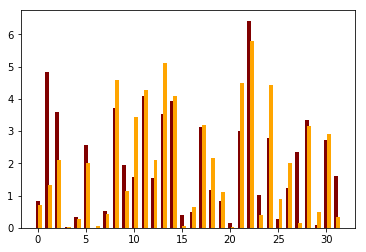

In [40]:
barWidth = 0.25
xlabels = range(32)
xlabels2 = [x + barWidth for x in xlabels]
plt.bar(xlabels, MeanBoVWTrain_formal_garden, color ='maroon', 
        width = 0.4)
plt.bar(xlabels2, MeanBoVWTest_formal_garden, color = 'orange',
       width = 0.4)

plt.show()

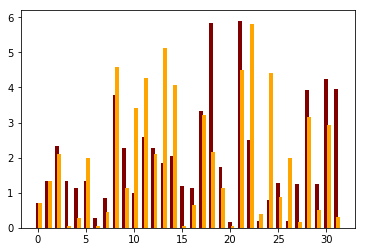

In [41]:
barWidth = 0.25
xlabels = range(32)
xlabels2 = [x + barWidth for x in xlabels]
plt.bar(xlabels, MeanBoVWTrain_engine_room, color ='maroon', 
        width = 0.4)
plt.bar(xlabels2, MeanBoVWTest_formal_garden, color = 'orange',
       width = 0.4)

plt.show()

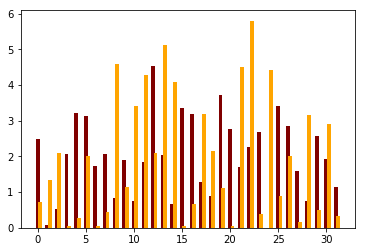

In [42]:
barWidth = 0.25
xlabels = range(32)
xlabels2 = [x + barWidth for x in xlabels]
plt.bar(xlabels, MeanBoVWTrain_basement, color ='maroon', 
        width = 0.4)
plt.bar(xlabels2, MeanBoVWTest_formal_garden, color = 'orange',
       width = 0.4)

plt.show()

# Using Bag of Visual Words to Classify Images

In [29]:
trainData = np.array(BoVWTrain)

In [30]:
testData = np.array(BoVWTest)

In [47]:
k = 3
Xtrain = []
Ytrain = np.zeros(k)

Xval = []
Yval = np.zeros(k)
for i in range(k):
    train, val = train_test_split(trainData[i], test_size=0.2, random_state=42, shuffle=True)
    for j in range(len(train)):
        Xtrain.append(train[j].reshape(1,-1))
        a = np.zeros(k)
        a[i] = 1
        Ytrain = np.vstack((Ytrain, a))
    
    for j in range(len(val)):
        Xval.append(val[j].reshape(1,-1))
        a = np.zeros(k)
        a[i] = 1
        Yval = np.vstack((Yval, a))
        
Ytrain = Ytrain[1:,:]
Xtrain = np.array(Xtrain).reshape(120,32)

Yval = Yval[1:,:]
Xval = np.array(Xval).reshape(30,32)

In [48]:
k = 3
Xtest = []
Ytest = np.zeros(k)

for i in range(k):
    for j in range(len(testData[i])):
        Xtest.append(testData[i][j].reshape(1,-1))
        a = np.zeros(k)
        a[i] = 1
        Ytest = np.vstack((Ytest, a))
        

Ytest = Ytest[1:,:]
Xtest = np.array(Xtest).reshape(150,32)

In [49]:
def checkParam(η, α, β, epochs, low, high):

    nn = MLNN.MLNN([32,80,80,3], ['logistic','logistic','softmax'], low, high)
    W, E = nn.fit(Xtrain, Ytrain, η, α, β, epochs)
    
    predTrain = np.argmax(nn.predict(Xtrain, β), axis = 1)
    actualTrain = np.argmax(Ytrain, axis = 1)
    trainCorrect = np.sum(predTrain == actualTrain)
    
    print('Accuracy on Training data =', trainCorrect/(len(actualTrain)))
    print('Confusion Matrix:')
    print(confusion_matrix(actualTrain, predTrain))
    
    predVal = np.argmax(nn.predict(Xval, β), axis = 1)
    actualVal = np.argmax(Yval, axis = 1)
    valCorrect = np.sum(predVal == actualVal)

    print('Accuracy on Validation data =', valCorrect/(len(actualVal)))
    print('Confusion Matrix:')
    print(confusion_matrix(actualVal, predVal))
    
    return nn, W

echo 0, error = 19.80
echo 1, error = 18.66
echo 2, error = 17.55
echo 3, error = 16.59
echo 4, error = 15.92
echo 5, error = 15.32
echo 6, error = 14.77
echo 7, error = 14.20
echo 8, error = 13.57
echo 9, error = 12.97
echo 10, error = 12.45
echo 11, error = 11.99
echo 12, error = 11.52
echo 13, error = 11.08
echo 14, error = 10.65
echo 15, error = 10.22
echo 16, error = 9.88
echo 17, error = 9.58
echo 18, error = 9.26
echo 19, error = 8.95
echo 20, error = 8.61
echo 21, error = 8.35
echo 22, error = 8.13
echo 23, error = 7.91
echo 24, error = 7.71
echo 25, error = 7.50
echo 26, error = 7.30
echo 27, error = 7.08
echo 28, error = 6.88
echo 29, error = 6.68
echo 30, error = 6.49
echo 31, error = 6.30
echo 32, error = 6.12
echo 33, error = 5.98
echo 34, error = 5.86
echo 35, error = 5.76
echo 36, error = 5.66
echo 37, error = 5.57
echo 38, error = 5.49
echo 39, error = 5.41
echo 40, error = 5.33
echo 41, error = 5.23
echo 42, error = 5.12
echo 43, error = 5.04
echo 44, error = 4.97
echo

echo 372, error = 0.90
echo 373, error = 0.89
echo 374, error = 0.89
echo 375, error = 0.89
echo 376, error = 0.89
echo 377, error = 0.89
echo 378, error = 0.89
echo 379, error = 0.88
echo 380, error = 0.88
echo 381, error = 0.88
echo 382, error = 0.88
echo 383, error = 0.88
echo 384, error = 0.88
echo 385, error = 0.88
echo 386, error = 0.87
echo 387, error = 0.87
echo 388, error = 0.87
echo 389, error = 0.87
echo 390, error = 0.87
echo 391, error = 0.87
echo 392, error = 0.87
echo 393, error = 0.87
echo 394, error = 0.86
echo 395, error = 0.86
echo 396, error = 0.86
echo 397, error = 0.86
echo 398, error = 0.87
echo 399, error = 0.88
echo 400, error = 0.89
echo 401, error = 0.89
echo 402, error = 0.88
echo 403, error = 0.88
echo 404, error = 0.88
echo 405, error = 0.88
echo 406, error = 0.88
echo 407, error = 0.88
echo 408, error = 0.88
echo 409, error = 0.88
echo 410, error = 0.88
echo 411, error = 0.88
echo 412, error = 0.87
echo 413, error = 0.87
echo 414, error = 0.87
echo 415, e

echo 740, error = 0.43
echo 741, error = 0.43
echo 742, error = 0.43
echo 743, error = 0.43
echo 744, error = 0.43
echo 745, error = 0.43
echo 746, error = 0.43
echo 747, error = 0.43
echo 748, error = 0.43
echo 749, error = 0.43
echo 750, error = 0.43
echo 751, error = 0.43
echo 752, error = 0.43
echo 753, error = 0.43
echo 754, error = 0.43
echo 755, error = 0.43
echo 756, error = 0.43
echo 757, error = 0.43
echo 758, error = 0.43
echo 759, error = 0.43
echo 760, error = 0.43
echo 761, error = 0.43
echo 762, error = 0.43
echo 763, error = 0.43
echo 764, error = 0.43
echo 765, error = 0.43
echo 766, error = 0.43
echo 767, error = 0.43
echo 768, error = 0.42
echo 769, error = 0.42
echo 770, error = 0.42
echo 771, error = 0.42
echo 772, error = 0.42
echo 773, error = 0.42
echo 774, error = 0.42
echo 775, error = 0.42
echo 776, error = 0.42
echo 777, error = 0.42
echo 778, error = 0.42
echo 779, error = 0.42
echo 780, error = 0.42
echo 781, error = 0.42
echo 782, error = 0.42
echo 783, e

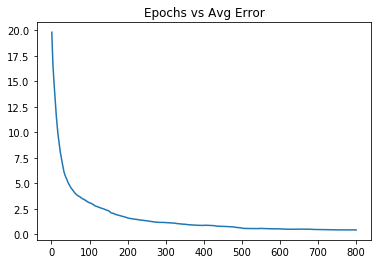

Accuracy on Training data = 0.9333333333333333
Confusion Matrix:
[[37  1  2]
 [ 0 37  3]
 [ 1  1 38]]
Accuracy on Validation data = 0.4
Confusion Matrix:
[[3 2 5]
 [1 3 6]
 [2 2 6]]


In [62]:
nn, W = checkParam(0.09, 0.4, 0.7, 800, -3, 3)

In [63]:
predTest = np.argmax(nn.predict(Xtest, 1), axis = 1)
actualTest = np.argmax(Ytest, axis = 1)
testCorrect = np.sum(predTest == actualTest)

print('Accuracy on Test data =', testCorrect/(len(actualTest)))
print('Confusion Matrix:')
print(confusion_matrix(actualTest, predTest))

Accuracy on Test data = 0.4266666666666667
Confusion Matrix:
[[15 10 25]
 [ 9 25 16]
 [11 15 24]]


## The Observation here is that though our accuracy is too good on training dataset but it still fails to do so on validation and test dataset as it is indeed overfitted and also our data, i.e., BoVW is very sparse matrix which is definitely not a good sign to train any data